In [51]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.core.pylabtools import figsize
from tqdm import tqdm

In [52]:
import holidays
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [53]:
import warnings
warnings.filterwarnings('ignore')

In [54]:
# sns.set()

## Read Data

In [55]:
os.listdir('input')

['test.csv', 'train_smoothed.csv', 'train.csv', 'sample_submission.csv']

In [56]:
train_df = pd.read_csv('input/train.csv')
print(train_df.shape)
train_df.head(1)

(136950, 6)


,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63


In [57]:
test_df = pd.read_csv('input/test.csv')
test_df.shape

(27375, 5)

In [58]:
sample_sub = pd.read_csv('input/sample_submission.csv')
print(sample_sub.shape)
sample_sub.head(1)

(27375, 2)


,id,num_sold
0,136950,100


## Get Holidays

In [59]:
train_df.country.unique()

array(['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain'], dtype=object)

In [60]:
start_date = train_df.date.min()
end_date = test_df.date.max()
start_date, end_date

('2017-01-01', '2022-12-31')

In [61]:
def get_national_holidays(country,
                          start_date=start_date,
                          end_date=end_date):
    holidays_days = holidays.CountryHoliday(country)
    date_range = pd.date_range(start_date, end_date)
    return [date for date in date_range
            if date in holidays_days]

In [62]:
common_holidays = pd.DataFrame({
    'ds': pd.to_datetime(['2017-04-16','2017-12-24', '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29', '2017-12-30', '2017-12-31',
                          '2018-04-01','2018-12-24', '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29', '2018-12-30', '2018-12-31',
                          '2019-04-21','2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29', '2019-12-30', '2019-12-31',
                          '2020-04-12','2020-12-24', '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-31',
                          '2021-04-04','2021-12-24', '2021-12-25', '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30', '2021-12-31',
                          '2022-04-17','2022-12-24', '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30', '2022-12-31']),
    'holiday': 'Holiday Season'
    })

In [63]:
country_holiday_dict = {country: pd.DataFrame({
    'holiday': country,
    'ds': pd.to_datetime(get_national_holidays(country))})
                        for country in train_df.country.unique()}

country_holiday_dict['Japan']

,holiday,ds
0,Japan,2017-01-01
1,Japan,2017-01-02
2,Japan,2017-01-09
3,Japan,2017-02-11
4,Japan,2017-03-20
...,...,...
105,Japan,2022-09-19
106,Japan,2022-09-23
107,Japan,2022-10-10
108,Japan,2022-11-03


In [64]:
for country in country_holiday_dict.keys():
    temp = country_holiday_dict[country].copy()
    temp = pd.concat([temp, common_holidays])
    country_holiday_dict[country] = temp
    
country_holiday_dict['Japan']

,holiday,ds
0,Japan,2017-01-01
1,Japan,2017-01-02
2,Japan,2017-01-09
3,Japan,2017-02-11
4,Japan,2017-03-20
...,...,...
49,Holiday Season,2022-12-27
50,Holiday Season,2022-12-28
51,Holiday Season,2022-12-29
52,Holiday Season,2022-12-30


## Data Examination

### Column Check

#### No duplicate `id`

In [65]:
train_df.id.unique().shape, test_df.id.unique().shape

((136950,), (27375,))

#### No new `country` shows up in the test set

In [66]:
train_df.country.unique(), test_df.country.unique()

(array(['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain'], dtype=object),
 array(['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain'], dtype=object))

#### No new `store` shows up in the test set

In [67]:
train_df.store.unique(), test_df.store.unique()

(array(['Kaggle Learn', 'Kaggle Store', 'Kagglazon'], dtype=object),
 array(['Kaggle Learn', 'Kaggle Store', 'Kagglazon'], dtype=object))

#### No new `product` shows up in the test set

In [68]:
train_df['product'].unique(), test_df['product'].unique()

(array(['Using LLMs to Improve Your Coding',
        'Using LLMs to Train More LLMs',
        'Using LLMs to Win Friends and Influence People',
        'Using LLMs to Win More Kaggle Competitions',
        'Using LLMs to Write Better'], dtype=object),
 array(['Using LLMs to Improve Your Coding',
        'Using LLMs to Train More LLMs',
        'Using LLMs to Win Friends and Influence People',
        'Using LLMs to Win More Kaggle Competitions',
        'Using LLMs to Write Better'], dtype=object))

## EDA

In [69]:
cats = ['country', 'store', 'product']
# temp = train_df.copy()
# temp['comb'] = temp[cats].apply(lambda x: '|'.join(list(x)), 
#                                 axis=1)
# temp = temp.pivot(index='date', 
#                   columns='comb',
#                   values='num_sold')
# temp.head()

In [70]:
# figsize(12, 8)

# fig, ax = plt.subplots(1, 1)

# for col in temp.columns:
#     if col.startswith('Canada|Kagglazon'):
#         sns.lineplot(temp.index,
#                      temp[col],
#                      label=col)
# plt.legend()

# xticklabels = [x.get_text() for x in ax.get_xticklabels()]
# xticks = []
# xlabels = []
# for i, label in enumerate(xticklabels, 0):
#     if label.endswith('-01'):
#         xlabels.append(label)
#         xticks.append(i)
        
# _ = ax.set_xticks(xticks, xlabels, rotation=90)

In [71]:
temp = train_df.copy()
temp_gb = temp.groupby(['date', 'country'])[['num_sold']].sum().reset_index()
temp_gb = temp_gb.pivot(index='date', columns='country', values='num_sold')
temp_gb.head()

country,Argentina,Canada,Estonia,Japan,Spain
date,,,,,
2017-01-01,2011,6134,2772,5274,3895
2017-01-02,1487,5081,2062,3983,2950
2017-01-03,1448,5049,1984,3742,2816
2017-01-04,1357,4710,1985,3784,2680
2017-01-05,1316,4629,1920,3609,2609


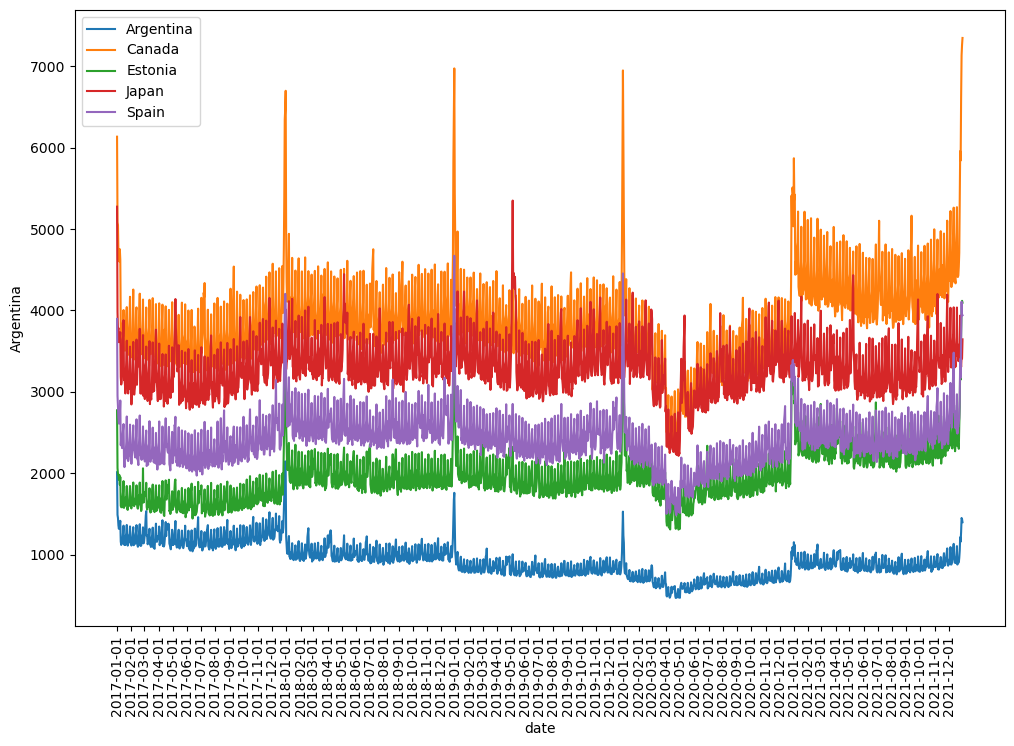

In [72]:
figsize(12, 8)

fig, ax = plt.subplots(1, 1)

for country in temp_gb.columns:
    sns.lineplot(temp_gb.index, temp_gb[country], label=country)
plt.legend()

xticklabels = [x.get_text() for x in ax.get_xticklabels()]
xticks = []
xlabels = []
for i, label in enumerate(xticklabels, 0):
    if label.endswith('-01'):
        xlabels.append(label)
        xticks.append(i)
        
_ = ax.set_xticks(xticks, xlabels, rotation=90)

## Modeling (Covid Smoothing)

### Pre-process

In [73]:
# pre_train_df = train_df.copy()
# pre_train_df = pre_train_df[pre_train_df.date < '2020-01-01']
# print(train_df.date.max(), pre_train_df.date.max())

In [74]:
def pre_process(df, cats=cats):
    df['comb'] = df[cats].apply(lambda x: '|'.join(list(x)), axis=1)
    df['y'] = df['num_sold']
    df['ds'] = df['date']
    groups_by_comb = df.groupby('comb')
    print(len(groups_by_comb.groups.keys()))
    
    return df, groups_by_comb

In [75]:
# pre_train_df, pre_groups_by_comb = pre_process(pre_train_df)

### Define Function

In [76]:
def train_and_forecast(group, country, 
                       country_holiday_dict=country_holiday_dict):
    # Train
    m = Prophet(yearly_seasonality=True,
                weekly_seasonality=True,
                holidays=country_holiday_dict[country])
    m.fit(group)
    
    # Predict
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    forecast['comb'] = group['comb'].iloc[0]
    
    # Return 
    return m, forecast

In [77]:
# pre_preds = pd.DataFrame()

# for comb in pre_train_df.comb.unique():
#     country = comb.split('|')[0]
#     group = pre_groups_by_comb.get_group(comb)
#     m, forecast = train_and_forecast(group, country)
#     pre_preds = pd.concat((pre_preds, forecast[['ds', 'comb', 'yhat']]))
    
# pre_preds.head()

In [78]:
# covid_preds = pre_preds[pre_preds.ds > '2019-12-31']
# covid_preds.shape[0] / 75

### Merge

In [79]:
# covid_preds['country'] = covid_preds['comb'].apply(lambda x: x.split('|')[0])
# covid_preds['store'] = covid_preds['comb'].apply(lambda x: x.split('|')[1])
# covid_preds['product'] = covid_preds['comb'].apply(lambda x: x.split('|')[2])
# covid_preds = covid_preds.drop('comb', axis=1)\
#                          .rename(columns={'ds': 'date',
#                                           'yhat': 'num_sold'})
# covid_preds['date'] = covid_preds['date'].apply(str).apply(lambda x: x.split(' ')[0])
# covid_preds.dtypes

In [81]:
covid_preds = pd.read_csv('input/train_smoothed.csv').drop('Unnamed: 0', axis=1)
covid_preds

,id,date,country,store,product,num_sold
0,82125,2020-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,27.892596
1,82126,2020-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,28.609150
2,82127,2020-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,3.792322
3,82128,2020-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,27.413845
4,82129,2020-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,21.181514
...,...,...,...,...,...,...
27445,109570,2020-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,628.047991
27446,109571,2020-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,555.908386
27447,109572,2020-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,89.051948
27448,109573,2020-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,558.111414


In [82]:
adj_train_df = train_df.copy()
adj_train_df = adj_train_df[(adj_train_df['date'] < '2020-01-01') | 
                            (adj_train_df['date'] > '2020-12-31')]
train_df.shape[0], adj_train_df.shape[0]

(136950, 109500)

In [84]:
covid_preds = covid_preds[adj_train_df.columns]
adj_train_df = pd.concat([adj_train_df, covid_preds])
train_df.shape, adj_train_df.shape

((136950, 6), (136950, 6))

In [86]:
train_df = adj_train_df.copy()
train_df.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63.0
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66.0
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9.0
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59.0
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49.0


In [87]:
temp = train_df.copy()
temp_gb = temp.groupby(['date', 'country'])[['num_sold']].sum().reset_index()
temp_gb = temp_gb.pivot(index='date', columns='country', values='num_sold')
temp_gb.head()

country,Argentina,Canada,Estonia,Japan,Spain
date,,,,,
2017-01-01,2011.0,6134.0,2772.0,5274.0,3895.0
2017-01-02,1487.0,5081.0,2062.0,3983.0,2950.0
2017-01-03,1448.0,5049.0,1984.0,3742.0,2816.0
2017-01-04,1357.0,4710.0,1985.0,3784.0,2680.0
2017-01-05,1316.0,4629.0,1920.0,3609.0,2609.0


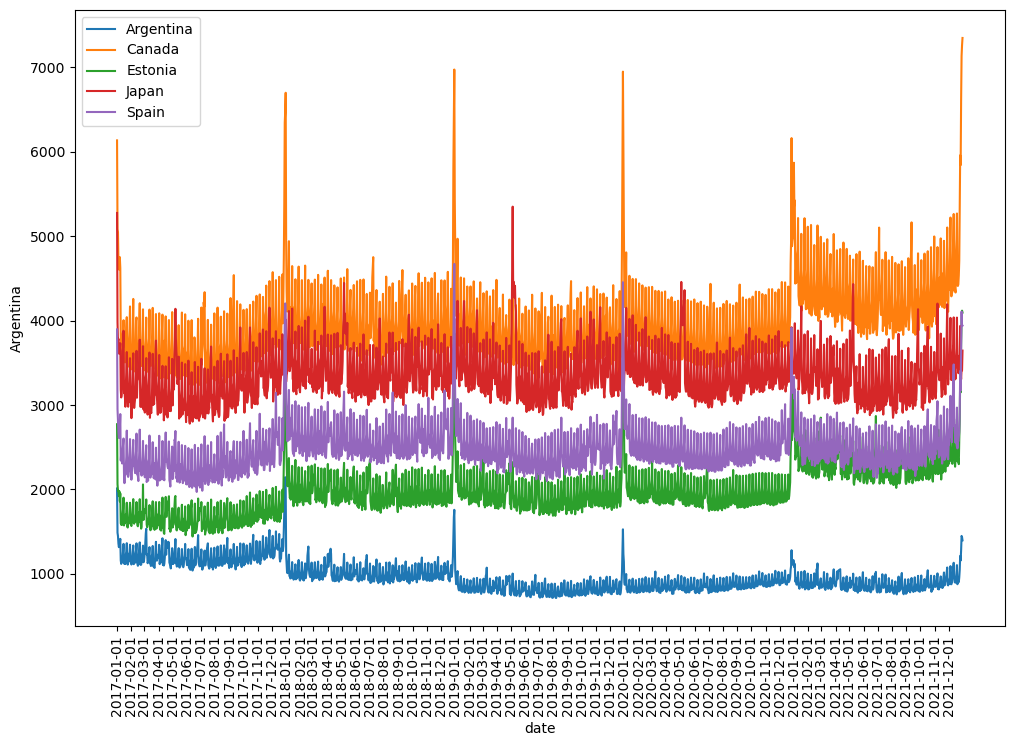

In [88]:
figsize(12, 8)

fig, ax = plt.subplots(1, 1)

for country in temp_gb.columns:
    sns.lineplot(temp_gb.index, temp_gb[country], label=country)
plt.legend()

xticklabels = [x.get_text() for x in ax.get_xticklabels()]
xticks = []
xlabels = []
for i, label in enumerate(xticklabels, 0):
    if label.endswith('-01'):
        xlabels.append(label)
        xticks.append(i)
        
_ = ax.set_xticks(xticks, xlabels, rotation=90)

## Model

In [89]:
train_df, groups_by_comb = pre_process(train_df)

75


In [90]:
preds = pd.DataFrame()
forecasts = []
models = []

for comb in train_df.comb.unique():
    country = comb.split('|')[0]
    group = groups_by_comb.get_group(comb)
    m, forecast = train_and_forecast(group, country)
    preds = pd.concat((preds, forecast[['ds', 'comb', 'yhat', 'yhat_upper', 'yhat_lower']]))
    models.append(m)
    forecasts.append(forecast)
    
preds.head()

14:59:03 - cmdstanpy - INFO - Chain [1] start processing
14:59:03 - cmdstanpy - INFO - Chain [1] done processing
14:59:04 - cmdstanpy - INFO - Chain [1] start processing
14:59:04 - cmdstanpy - INFO - Chain [1] done processing
14:59:05 - cmdstanpy - INFO - Chain [1] start processing
14:59:05 - cmdstanpy - INFO - Chain [1] done processing
14:59:06 - cmdstanpy - INFO - Chain [1] start processing
14:59:06 - cmdstanpy - INFO - Chain [1] done processing
14:59:07 - cmdstanpy - INFO - Chain [1] start processing
14:59:07 - cmdstanpy - INFO - Chain [1] done processing
14:59:08 - cmdstanpy - INFO - Chain [1] start processing
14:59:08 - cmdstanpy - INFO - Chain [1] done processing
14:59:09 - cmdstanpy - INFO - Chain [1] start processing
14:59:09 - cmdstanpy - INFO - Chain [1] done processing
14:59:10 - cmdstanpy - INFO - Chain [1] start processing
14:59:10 - cmdstanpy - INFO - Chain [1] done processing
14:59:11 - cmdstanpy - INFO - Chain [1] start processing
14:59:11 - cmdstanpy - INFO - Chain [1]

15:00:26 - cmdstanpy - INFO - Chain [1] done processing
15:00:27 - cmdstanpy - INFO - Chain [1] start processing
15:00:27 - cmdstanpy - INFO - Chain [1] done processing
15:00:28 - cmdstanpy - INFO - Chain [1] start processing
15:00:28 - cmdstanpy - INFO - Chain [1] done processing


,ds,comb,yhat,yhat_upper,yhat_lower
0,2017-01-01,Argentina|Kaggle Learn|Using LLMs to Improve Y...,44.218398,47.198466,40.876361
1,2017-01-02,Argentina|Kaggle Learn|Using LLMs to Improve Y...,39.131755,42.335913,36.127133
2,2017-01-03,Argentina|Kaggle Learn|Using LLMs to Improve Y...,38.675513,41.658094,35.639122
3,2017-01-04,Argentina|Kaggle Learn|Using LLMs to Improve Y...,38.747891,41.932561,35.626140
4,2017-01-05,Argentina|Kaggle Learn|Using LLMs to Improve Y...,38.478561,41.389318,35.505146


## Evaluation

In [93]:
def get_metrics(m):
    m_cv = cross_validation(model=m, 
                            initial='1460 days',
                            period='30 days',
                            horizon='365 days')
    pm = performance_metrics(m_cv)
    return pm[pm['horizon'] == '365 days'][['rmse', 'smape']].values[0]

In [94]:
metrics = [get_metrics(m) for m in tqdm(models)]



  0%|                                                    | 0/75 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:30 - cmdstanpy - INFO - Chain [1] start processing
15:01:30 - cmdstanpy - INFO - Chain [1] done processing


  1%|▌                                           | 1/75 [00:01<01:49,  1.48s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:32 - cmdstanpy - INFO - Chain [1] start processing
15:01:32 - cmdstanpy - INFO - Chain [1] done processing


  3%|█▏                                          | 2/75 [00:03<02:00,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:33 - cmdstanpy - INFO - Chain [1] start processing
15:01:34 - cmdstanpy - INFO - Chain [1] done processing


  4%|█▊                                          | 3/75 [00:04<01:50,  1.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:35 - cmdstanpy - INFO - Chain [1] start processing
15:01:35 - cmdstanpy - INFO - Chain [1] done processing


  5%|██▎                                         | 4/75 [00:06<01:54,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:37 - cmdstanpy - INFO - Chain [1] start processing
15:01:37 - cmdstanpy - INFO - Chain [1] done processing


  7%|██▉                                         | 5/75 [00:07<01:46,  1.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:38 - cmdstanpy - INFO - Chain [1] start processing
15:01:38 - cmdstanpy - INFO - Chain [1] done processing


  8%|███▌                                        | 6/75 [00:09<01:41,  1.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:39 - cmdstanpy - INFO - Chain [1] start processing
15:01:39 - cmdstanpy - INFO - Chain [1] done processing


  9%|████                                        | 7/75 [00:10<01:48,  1.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:41 - cmdstanpy - INFO - Chain [1] start processing
15:01:41 - cmdstanpy - INFO - Chain [1] done processing


 11%|████▋                                       | 8/75 [00:12<01:42,  1.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:42 - cmdstanpy - INFO - Chain [1] start processing
15:01:43 - cmdstanpy - INFO - Chain [1] done processing


 12%|█████▎                                      | 9/75 [00:13<01:41,  1.55s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:44 - cmdstanpy - INFO - Chain [1] start processing
15:01:44 - cmdstanpy - INFO - Chain [1] done processing


 13%|█████▋                                     | 10/75 [00:15<01:37,  1.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:45 - cmdstanpy - INFO - Chain [1] start processing
15:01:46 - cmdstanpy - INFO - Chain [1] done processing


 15%|██████▎                                    | 11/75 [00:16<01:37,  1.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:47 - cmdstanpy - INFO - Chain [1] start processing
15:01:47 - cmdstanpy - INFO - Chain [1] done processing


 16%|██████▉                                    | 12/75 [00:18<01:36,  1.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:49 - cmdstanpy - INFO - Chain [1] start processing
15:01:49 - cmdstanpy - INFO - Chain [1] done processing


 17%|███████▍                                   | 13/75 [00:19<01:34,  1.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:50 - cmdstanpy - INFO - Chain [1] start processing
15:01:50 - cmdstanpy - INFO - Chain [1] done processing


 19%|████████                                   | 14/75 [00:21<01:32,  1.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:52 - cmdstanpy - INFO - Chain [1] start processing
15:01:52 - cmdstanpy - INFO - Chain [1] done processing


 20%|████████▌                                  | 15/75 [00:22<01:29,  1.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:53 - cmdstanpy - INFO - Chain [1] start processing
15:01:53 - cmdstanpy - INFO - Chain [1] done processing


 21%|█████████▏                                 | 16/75 [00:24<01:26,  1.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:54 - cmdstanpy - INFO - Chain [1] start processing
15:01:55 - cmdstanpy - INFO - Chain [1] done processing


 23%|█████████▋                                 | 17/75 [00:25<01:26,  1.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:56 - cmdstanpy - INFO - Chain [1] start processing
15:01:56 - cmdstanpy - INFO - Chain [1] done processing


 24%|██████████▎                                | 18/75 [00:27<01:25,  1.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:58 - cmdstanpy - INFO - Chain [1] start processing
15:01:58 - cmdstanpy - INFO - Chain [1] done processing


 25%|██████████▉                                | 19/75 [00:29<01:30,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:01:59 - cmdstanpy - INFO - Chain [1] start processing
15:01:59 - cmdstanpy - INFO - Chain [1] done processing


 27%|███████████▍                               | 20/75 [00:30<01:22,  1.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:01 - cmdstanpy - INFO - Chain [1] start processing
15:02:01 - cmdstanpy - INFO - Chain [1] done processing


 28%|████████████                               | 21/75 [00:31<01:17,  1.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:02 - cmdstanpy - INFO - Chain [1] start processing
15:02:02 - cmdstanpy - INFO - Chain [1] done processing


 29%|████████████▌                              | 22/75 [00:33<01:16,  1.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:03 - cmdstanpy - INFO - Chain [1] start processing
15:02:04 - cmdstanpy - INFO - Chain [1] done processing


 31%|█████████████▏                             | 23/75 [00:34<01:16,  1.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:05 - cmdstanpy - INFO - Chain [1] start processing
15:02:05 - cmdstanpy - INFO - Chain [1] done processing


 32%|█████████████▊                             | 24/75 [00:36<01:15,  1.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:06 - cmdstanpy - INFO - Chain [1] start processing
15:02:07 - cmdstanpy - INFO - Chain [1] done processing


 33%|██████████████▎                            | 25/75 [00:37<01:13,  1.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:08 - cmdstanpy - INFO - Chain [1] start processing
15:02:08 - cmdstanpy - INFO - Chain [1] done processing


 35%|██████████████▉                            | 26/75 [00:39<01:12,  1.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:09 - cmdstanpy - INFO - Chain [1] start processing
15:02:10 - cmdstanpy - INFO - Chain [1] done processing


 36%|███████████████▍                           | 27/75 [00:40<01:12,  1.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:11 - cmdstanpy - INFO - Chain [1] start processing
15:02:11 - cmdstanpy - INFO - Chain [1] done processing


 37%|████████████████                           | 28/75 [00:42<01:10,  1.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:12 - cmdstanpy - INFO - Chain [1] start processing
15:02:13 - cmdstanpy - INFO - Chain [1] done processing


 39%|████████████████▋                          | 29/75 [00:43<01:09,  1.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:14 - cmdstanpy - INFO - Chain [1] start processing
15:02:14 - cmdstanpy - INFO - Chain [1] done processing


 40%|█████████████████▏                         | 30/75 [00:45<01:14,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:16 - cmdstanpy - INFO - Chain [1] start processing
15:02:16 - cmdstanpy - INFO - Chain [1] done processing


 41%|█████████████████▊                         | 31/75 [00:47<01:13,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:18 - cmdstanpy - INFO - Chain [1] start processing
15:02:18 - cmdstanpy - INFO - Chain [1] done processing


 43%|██████████████████▎                        | 32/75 [00:49<01:17,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:20 - cmdstanpy - INFO - Chain [1] start processing
15:02:20 - cmdstanpy - INFO - Chain [1] done processing


 44%|██████████████████▉                        | 33/75 [00:51<01:14,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:21 - cmdstanpy - INFO - Chain [1] start processing
15:02:22 - cmdstanpy - INFO - Chain [1] done processing


 45%|███████████████████▍                       | 34/75 [00:52<01:10,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:23 - cmdstanpy - INFO - Chain [1] start processing
15:02:23 - cmdstanpy - INFO - Chain [1] done processing


 47%|████████████████████                       | 35/75 [00:54<01:06,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:25 - cmdstanpy - INFO - Chain [1] start processing
15:02:25 - cmdstanpy - INFO - Chain [1] done processing


 48%|████████████████████▋                      | 36/75 [00:56<01:06,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:26 - cmdstanpy - INFO - Chain [1] start processing
15:02:27 - cmdstanpy - INFO - Chain [1] done processing


 49%|█████████████████████▏                     | 37/75 [00:57<01:02,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:28 - cmdstanpy - INFO - Chain [1] start processing
15:02:28 - cmdstanpy - INFO - Chain [1] done processing


 51%|█████████████████████▊                     | 38/75 [00:59<00:59,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:29 - cmdstanpy - INFO - Chain [1] start processing
15:02:30 - cmdstanpy - INFO - Chain [1] done processing


 52%|██████████████████████▎                    | 39/75 [01:00<00:58,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:31 - cmdstanpy - INFO - Chain [1] start processing
15:02:31 - cmdstanpy - INFO - Chain [1] done processing


 53%|██████████████████████▉                    | 40/75 [01:02<00:53,  1.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:32 - cmdstanpy - INFO - Chain [1] start processing
15:02:33 - cmdstanpy - INFO - Chain [1] done processing


 55%|███████████████████████▌                   | 41/75 [01:03<00:49,  1.46s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:34 - cmdstanpy - INFO - Chain [1] start processing
15:02:34 - cmdstanpy - INFO - Chain [1] done processing


 56%|████████████████████████                   | 42/75 [01:04<00:46,  1.42s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:35 - cmdstanpy - INFO - Chain [1] start processing
15:02:35 - cmdstanpy - INFO - Chain [1] done processing


 57%|████████████████████████▋                  | 43/75 [01:06<00:46,  1.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:37 - cmdstanpy - INFO - Chain [1] start processing
15:02:37 - cmdstanpy - INFO - Chain [1] done processing


 59%|█████████████████████████▏                 | 44/75 [01:07<00:43,  1.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:38 - cmdstanpy - INFO - Chain [1] start processing
15:02:38 - cmdstanpy - INFO - Chain [1] done processing


 60%|█████████████████████████▊                 | 45/75 [01:08<00:40,  1.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:39 - cmdstanpy - INFO - Chain [1] start processing
15:02:39 - cmdstanpy - INFO - Chain [1] done processing


 61%|██████████████████████████▎                | 46/75 [01:10<00:40,  1.40s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:41 - cmdstanpy - INFO - Chain [1] start processing
15:02:41 - cmdstanpy - INFO - Chain [1] done processing


 63%|██████████████████████████▉                | 47/75 [01:12<00:40,  1.45s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:42 - cmdstanpy - INFO - Chain [1] start processing
15:02:42 - cmdstanpy - INFO - Chain [1] done processing


 64%|███████████████████████████▌               | 48/75 [01:13<00:38,  1.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:44 - cmdstanpy - INFO - Chain [1] start processing
15:02:44 - cmdstanpy - INFO - Chain [1] done processing


 65%|████████████████████████████               | 49/75 [01:14<00:36,  1.40s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:45 - cmdstanpy - INFO - Chain [1] start processing
15:02:45 - cmdstanpy - INFO - Chain [1] done processing


 67%|████████████████████████████▋              | 50/75 [01:16<00:34,  1.40s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:46 - cmdstanpy - INFO - Chain [1] start processing
15:02:46 - cmdstanpy - INFO - Chain [1] done processing


 68%|█████████████████████████████▏             | 51/75 [01:17<00:32,  1.37s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:48 - cmdstanpy - INFO - Chain [1] start processing
15:02:48 - cmdstanpy - INFO - Chain [1] done processing


 69%|█████████████████████████████▊             | 52/75 [01:18<00:31,  1.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:49 - cmdstanpy - INFO - Chain [1] start processing
15:02:49 - cmdstanpy - INFO - Chain [1] done processing


 71%|██████████████████████████████▍            | 53/75 [01:20<00:29,  1.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:50 - cmdstanpy - INFO - Chain [1] start processing
15:02:50 - cmdstanpy - INFO - Chain [1] done processing


 72%|██████████████████████████████▉            | 54/75 [01:21<00:28,  1.33s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:52 - cmdstanpy - INFO - Chain [1] start processing
15:02:52 - cmdstanpy - INFO - Chain [1] done processing


 73%|███████████████████████████████▌           | 55/75 [01:22<00:26,  1.33s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:53 - cmdstanpy - INFO - Chain [1] start processing
15:02:53 - cmdstanpy - INFO - Chain [1] done processing


 75%|████████████████████████████████           | 56/75 [01:24<00:25,  1.33s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:54 - cmdstanpy - INFO - Chain [1] start processing
15:02:54 - cmdstanpy - INFO - Chain [1] done processing


 76%|████████████████████████████████▋          | 57/75 [01:25<00:23,  1.33s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:56 - cmdstanpy - INFO - Chain [1] start processing
15:02:56 - cmdstanpy - INFO - Chain [1] done processing


 77%|█████████████████████████████████▎         | 58/75 [01:26<00:22,  1.33s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:57 - cmdstanpy - INFO - Chain [1] start processing
15:02:57 - cmdstanpy - INFO - Chain [1] done processing


 79%|█████████████████████████████████▊         | 59/75 [01:28<00:22,  1.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:02:58 - cmdstanpy - INFO - Chain [1] start processing
15:02:59 - cmdstanpy - INFO - Chain [1] done processing


 80%|██████████████████████████████████▍        | 60/75 [01:29<00:20,  1.37s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:03:00 - cmdstanpy - INFO - Chain [1] start processing
15:03:00 - cmdstanpy - INFO - Chain [1] done processing


 81%|██████████████████████████████████▉        | 61/75 [01:30<00:19,  1.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:03:01 - cmdstanpy - INFO - Chain [1] start processing
15:03:01 - cmdstanpy - INFO - Chain [1] done processing


 83%|███████████████████████████████████▌       | 62/75 [01:32<00:17,  1.33s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:03:02 - cmdstanpy - INFO - Chain [1] start processing
15:03:03 - cmdstanpy - INFO - Chain [1] done processing


 84%|████████████████████████████████████       | 63/75 [01:33<00:15,  1.33s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:03:04 - cmdstanpy - INFO - Chain [1] start processing
15:03:04 - cmdstanpy - INFO - Chain [1] done processing


 85%|████████████████████████████████████▋      | 64/75 [01:34<00:14,  1.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:03:05 - cmdstanpy - INFO - Chain [1] start processing
15:03:05 - cmdstanpy - INFO - Chain [1] done processing


 87%|█████████████████████████████████████▎     | 65/75 [01:36<00:13,  1.31s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:03:06 - cmdstanpy - INFO - Chain [1] start processing
15:03:06 - cmdstanpy - INFO - Chain [1] done processing


 88%|█████████████████████████████████████▊     | 66/75 [01:37<00:11,  1.31s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:03:08 - cmdstanpy - INFO - Chain [1] start processing
15:03:08 - cmdstanpy - INFO - Chain [1] done processing


 89%|██████████████████████████████████████▍    | 67/75 [01:38<00:10,  1.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:03:09 - cmdstanpy - INFO - Chain [1] start processing
15:03:09 - cmdstanpy - INFO - Chain [1] done processing


 91%|██████████████████████████████████████▉    | 68/75 [01:40<00:09,  1.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:03:10 - cmdstanpy - INFO - Chain [1] start processing
15:03:10 - cmdstanpy - INFO - Chain [1] done processing


 92%|███████████████████████████████████████▌   | 69/75 [01:41<00:07,  1.31s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:03:12 - cmdstanpy - INFO - Chain [1] start processing
15:03:12 - cmdstanpy - INFO - Chain [1] done processing


 93%|████████████████████████████████████████▏  | 70/75 [01:42<00:06,  1.31s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:03:13 - cmdstanpy - INFO - Chain [1] start processing
15:03:13 - cmdstanpy - INFO - Chain [1] done processing


 95%|████████████████████████████████████████▋  | 71/75 [01:43<00:05,  1.30s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:03:14 - cmdstanpy - INFO - Chain [1] start processing
15:03:14 - cmdstanpy - INFO - Chain [1] done processing


 96%|█████████████████████████████████████████▎ | 72/75 [01:45<00:03,  1.30s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:03:15 - cmdstanpy - INFO - Chain [1] start processing
15:03:16 - cmdstanpy - INFO - Chain [1] done processing


 97%|█████████████████████████████████████████▊ | 73/75 [01:46<00:02,  1.31s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:03:17 - cmdstanpy - INFO - Chain [1] start processing
15:03:17 - cmdstanpy - INFO - Chain [1] done processing


 99%|██████████████████████████████████████████▍| 74/75 [01:47<00:01,  1.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

15:03:18 - cmdstanpy - INFO - Chain [1] start processing
15:03:18 - cmdstanpy - INFO - Chain [1] done processing


100%|███████████████████████████████████████████| 75/75 [01:49<00:00,  1.46s/it]


In [95]:
for i, comb in enumerate(train_df.comb.unique(), 0):
    print(comb, f'{metrics[i][1] * 100:.2f}', '|', f'{metrics[i][0]:.2f}')

Argentina|Kaggle Learn|Using LLMs to Improve Your Coding 9.62 | 4.33
Argentina|Kaggle Learn|Using LLMs to Train More LLMs 11.96 | 4.94
Argentina|Kaggle Learn|Using LLMs to Win Friends and Influence People 12.69 | 0.79
Argentina|Kaggle Learn|Using LLMs to Win More Kaggle Competitions 10.47 | 4.38
Argentina|Kaggle Learn|Using LLMs to Write Better 20.49 | 5.56
Argentina|Kaggle Store|Using LLMs to Improve Your Coding 12.80 | 7.76
Argentina|Kaggle Store|Using LLMs to Train More LLMs 15.71 | 8.76
Argentina|Kaggle Store|Using LLMs to Win Friends and Influence People 12.59 | 1.24
Argentina|Kaggle Store|Using LLMs to Win More Kaggle Competitions 8.62 | 5.43
Argentina|Kaggle Store|Using LLMs to Write Better 18.84 | 7.96
Argentina|Kagglazon|Using LLMs to Improve Your Coding 11.42 | 26.29
Argentina|Kagglazon|Using LLMs to Train More LLMs 21.82 | 41.81
Argentina|Kagglazon|Using LLMs to Win Friends and Influence People 10.05 | 4.19
Argentina|Kagglazon|Using LLMs to Win More Kaggle Competitions 8.05 

In [96]:
print(f'Average SMAPE: {np.mean([m[1] for m in metrics]) * 100:.5f}')
print(f'Average RMSE: {np.mean([m[0] for m in metrics]):.2f}')

Average SMAPE: 13.75178
Average RMSE: 31.80


## Submission

In [97]:
subs = preds[preds.ds > train_df.ds.max()]
subs = subs.rename(columns={'ds': 'date',
                            'yhat': 'num_sold'})
subs['date'] = subs['date'].apply(str).apply(lambda x: x.split(' ')[0])
subs.head(1)

,date,comb,num_sold,yhat_upper,yhat_lower
1826,2022-01-01,Argentina|Kaggle Learn|Using LLMs to Improve Y...,31.265978,34.35245,27.963169


In [98]:
test_df['comb'] = test_df[cats].apply(lambda x: '|'.join(list(x)), 
                                      axis=1)
test_df.head(1)

,id,date,country,store,product,comb
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,Argentina|Kaggle Learn|Using LLMs to Improve Y...


In [99]:
test_df = test_df.merge(subs, how='left', on=['date', 'comb'])
test_df.head(1)

,id,date,country,store,product,comb,num_sold,yhat_upper,yhat_lower
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,Argentina|Kaggle Learn|Using LLMs to Improve Y...,31.265978,34.35245,27.963169


In [100]:
# test_df[['id', 'num_sold']].to_csv('subs/sub_5_sm.csv', index=False)